In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/mlbio1/train.csv
/kaggle/input/mlbio1/test.csv
/kaggle/input/mlbio1/sample_submission.csv


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
pd.options.display.max_columns = 100

In [10]:
#FOR Kaggle
sample = pd.read_csv('/kaggle/input/mlbio1/sample_submission.csv')
test = pd.read_csv('/kaggle/input/mlbio1/test.csv')
train = pd.read_csv('/kaggle/input/mlbio1/train.csv')

#For local
# sample = pd.read_csv('healthcare-dataset-stroke-data/sample_submission.csv')
# test = pd.read_csv('healthcare-dataset-stroke-data/test.csv')
# train = pd.read_csv('healthcare-dataset-stroke-data/train.csv')

In [11]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


# Filling NA 

In [12]:
#counts of nan
for i in train.columns:
    print(i, (pd.isnull(train[i])).sum() )

id 0
gender 0
age 0
hypertension 0
heart_disease 0
ever_married 0
work_type 0
Residence_type 0
avg_glucose_level 0
bmi 1017
smoking_status 9176
stroke 0


In [13]:
train['bmi'].head()   #bmi is numeric column

0    18.0
1    39.2
2    17.6
3    35.9
4    19.1
Name: bmi, dtype: float64

In [14]:
# fill with mean
mean_bmi = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(mean_bmi)
test['bmi'] = test['bmi'].fillna(mean_bmi)

In [15]:
# fill with median
# median_bmi = train['bmi'].median()
# train['bmi'] = train['bmi'].fillna(median_bmi)
# test['bmi'] = test['bmi'].fillna(median_bmi)

In [16]:
# fill with zero

# train['bmi'] = train['bmi'].fillna(0)
# test['bmi'] = test['bmi'].fillna(0)

In [17]:
train['smoking_status'].head()   #smoking_status is categorical column

0                NaN
1       never smoked
2                NaN
3    formerly smoked
4                NaN
Name: smoking_status, dtype: object

In [18]:
train['smoking_status'] = train['smoking_status'].fillna('nan')
test['smoking_status'] = test['smoking_status'].fillna('nan')

# Replacement of categorical values with number

In [19]:
train['work_type'].value_counts()

Private          17220
Self-employed     4674
children          4188
Govt_job          3804
Never_worked       115
Name: work_type, dtype: int64

In [20]:
for i in train['work_type'].unique():
    print(i)
    train['work_type_is_{}'.format(i)] = (train['work_type'] == i)*1
    test['work_type_is_{}'.format(i)] = (test['work_type'] == i)*1

children
Private
Never_worked
Self-employed
Govt_job


In [21]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,nan,0,1,0,0,0,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0,0,1,0,0,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,nan,0,0,1,0,0,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0,0,1,0,0,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,nan,0,0,0,1,0,0


# Encoding of target

In [22]:
(train.groupby(['smoking_status'])['stroke'].agg(['mean'])).to_dict()

{'mean': {'formerly smoked': 0.027783137179239824,
  'nan': 0.011442894507410636,
  'never smoked': 0.01723982308872642,
  'smokes': 0.01972386587771203}}

In [23]:
smoking_status_target_enc_dict = (train.groupby(['smoking_status'])['stroke'].agg(['mean'])).to_dict()['mean']

In [24]:
smoking_status_target_enc_dict

{'formerly smoked': 0.027783137179239824,
 'nan': 0.011442894507410636,
 'never smoked': 0.01723982308872642,
 'smokes': 0.01972386587771203}

In [28]:
train['smoking_status_target_enc'] = train['smoking_status'].replace(smoking_status_target_enc_dict)
test['smoking_status_target_enc'] = test['smoking_status'].replace(smoking_status_target_enc_dict)

In [29]:
# Binary variables 
train['ever_married'].value_counts() 

1    19376
0    10625
Name: ever_married, dtype: int64

In [30]:
train['ever_married'] = train['ever_married'].replace({'Yes':1, 'No':0 })
test['ever_married'] = test['ever_married'].replace({'Yes':1, 'No':0 })

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [31]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job,smoking_status_target_enc
0,30669,Male,3.0,0,0,0,children,Rural,95.12,18.0,nan,0,1,0,0,0,0,0.011443
1,30468,Male,58.0,1,0,1,Private,Urban,87.96,39.2,never smoked,0,0,1,0,0,0,0.017240
2,16523,Female,8.0,0,0,0,Private,Urban,110.89,17.6,nan,0,0,1,0,0,0,0.011443
3,56543,Female,70.0,0,0,1,Private,Rural,69.04,35.9,formerly smoked,0,0,1,0,0,0,0.027783
4,46136,Male,14.0,0,0,0,Never_worked,Rural,161.28,19.1,nan,0,0,0,1,0,0,0.011443


In [32]:
train['Residence_type'].value_counts()

Urban    15028
Rural    14973
Name: Residence_type, dtype: int64

In [33]:
train['Residence_type'] = train['Residence_type'].replace({'Urban':1, 'Rural':0 })
test['Residence_type'] = test['Residence_type'].replace({'Urban':1, 'Rural':0 })

In [34]:
# smoking_status binary encoding
for i in train['smoking_status'].unique():
    print(i)
    train['smoking_status_is_{}'.format(i)] = (train['smoking_status'] == i)*1
    test['smoking_status_is_{}'.format(i)] = (test['smoking_status'] == i)*1

nan
never smoked
formerly smoked
smokes


In [35]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job,smoking_status_target_enc,smoking_status_is_nan,smoking_status_is_never smoked,smoking_status_is_formerly smoked,smoking_status_is_smokes
0,30669,Male,3.0,0,0,0,children,0,95.12,18.0,nan,0,1,0,0,0,0,0.011443,1,0,0,0
1,30468,Male,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0,0,1,0,0,0,0.017240,0,1,0,0
2,16523,Female,8.0,0,0,0,Private,1,110.89,17.6,nan,0,0,1,0,0,0,0.011443,1,0,0,0
3,56543,Female,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0,0,1,0,0,0,0.027783,0,0,1,0
4,46136,Male,14.0,0,0,0,Never_worked,0,161.28,19.1,nan,0,0,0,1,0,0,0.011443,1,0,0,0


In [36]:
train['gender'].value_counts()

Female    17676
Male      12315
Other        10
Name: gender, dtype: int64

In [37]:
(train.groupby(['gender'])['stroke'].agg(['mean']))

,mean
gender,
Female,0.016576
Male,0.019245
Other,0.000000


In [38]:
gender_target_enc_dict = (train.groupby(['gender'])['stroke'].agg(['mean'])).to_dict()['mean']

train['gender_target_enc'] = train['gender'].replace(gender_target_enc_dict)
test['gender_target_enc'] = test['gender'].replace(gender_target_enc_dict)


In [39]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job,smoking_status_target_enc,smoking_status_is_nan,smoking_status_is_never smoked,smoking_status_is_formerly smoked,smoking_status_is_smokes,gender_target_enc
0,30669,Male,3.0,0,0,0,children,0,95.12,18.0,nan,0,1,0,0,0,0,0.011443,1,0,0,0,0.019245
1,30468,Male,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0,0,1,0,0,0,0.017240,0,1,0,0,0.019245
2,16523,Female,8.0,0,0,0,Private,1,110.89,17.6,nan,0,0,1,0,0,0,0.011443,1,0,0,0,0.016576
3,56543,Female,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0,0,1,0,0,0,0.027783,0,0,1,0,0.016576
4,46136,Male,14.0,0,0,0,Never_worked,0,161.28,19.1,nan,0,0,0,1,0,0,0.011443,1,0,0,0,0.019245


# Cross validation

In [41]:
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

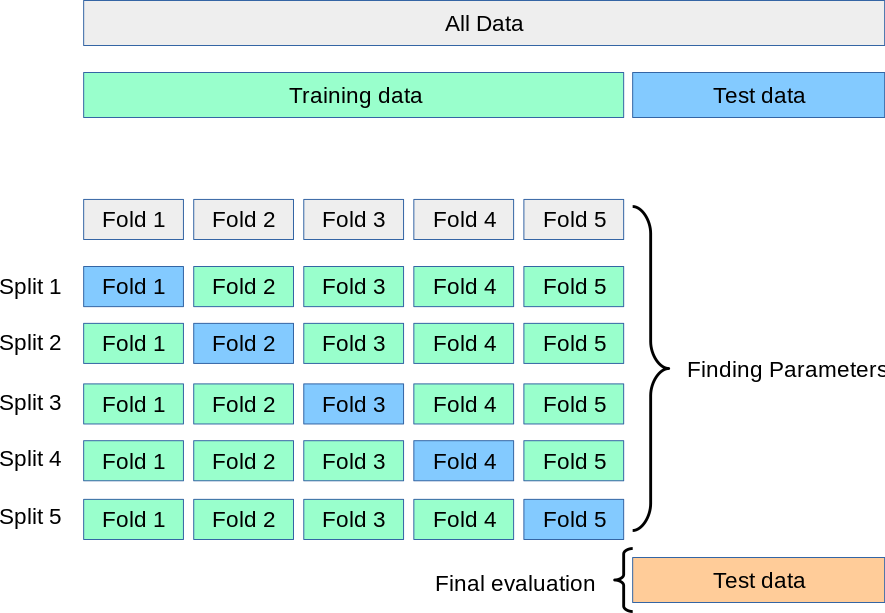

In [42]:
from sklearn.metrics import roc_auc_score


In [43]:
# I select 7 features

In [44]:
features = [  'age',
            'hypertension' , 'heart_disease' , 'ever_married' ,
            'avg_glucose_level' ,'bmi']

In [45]:
clf = linear_model.SGDClassifier(max_iter=1000,  loss='log', penalty = 'elasticnet')

In [46]:
#DIY

def my_cross_validation_for_roc_auc( clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
        
    return scores
        


In [47]:
scores = my_cross_validation_for_roc_auc(clf, train[features] , train['stroke'])

In [48]:
scores

[0.8317271323879253,
 0.8468040396173877,
 0.8223414916440832,
 0.8406320076472842,
 0.8325041801862993]

In [49]:
# mean score on train dataset
np.mean(scores)

0.8348017702965957

# Feature selection

In [50]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job,smoking_status_target_enc,smoking_status_is_nan,smoking_status_is_never smoked,smoking_status_is_formerly smoked,smoking_status_is_smokes,gender_target_enc
0,30669,Male,3.0,0,0,0,children,0,95.12,18.0,nan,0,1,0,0,0,0,0.011443,1,0,0,0,0.019245
1,30468,Male,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0,0,1,0,0,0,0.017240,0,1,0,0,0.019245
2,16523,Female,8.0,0,0,0,Private,1,110.89,17.6,nan,0,0,1,0,0,0,0.011443,1,0,0,0,0.016576
3,56543,Female,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0,0,1,0,0,0,0.027783,0,0,1,0,0.016576
4,46136,Male,14.0,0,0,0,Never_worked,0,161.28,19.1,nan,0,0,0,1,0,0,0.011443,1,0,0,0,0.019245


In [51]:
all_features = [ 'age', 'hypertension', 'heart_disease', 'ever_married',
        'Residence_type', 'avg_glucose_level', 'bmi',
         'work_type_is_children',
       'work_type_is_Private', 'work_type_is_Never_worked',
       'work_type_is_Self-employed', 'work_type_is_Govt_job',
       'smoking_status_target_enc', 'smoking_status_is_nan',
       'smoking_status_is_never smoked', 'smoking_status_is_formerly smoked',
       'smoking_status_is_smokes', 'gender_target_enc']

In [52]:
features_scores = {}
for f in all_features:
    scores = my_cross_validation_for_roc_auc(clf, train[[f]] , train['stroke'])
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

age 0.8366076869311634
hypertension 0.581615320246325
heart_disease 0.5818777239077606
ever_married 0.6259899654630761
Residence_type 0.5
avg_glucose_level 0.5526205277506291
bmi 0.5118604265469738
work_type_is_children 0.5689884334400628
work_type_is_Private 0.4980171903078142
work_type_is_Never_worked 0.5019511976545372
work_type_is_Self-employed 0.5634987850302702
work_type_is_Govt_job 0.49245321038086975
smoking_status_target_enc 0.5854061511636889
smoking_status_is_nan 0.5556075662992808
smoking_status_is_never smoked 0.5
smoking_status_is_formerly smoked 0.5513657296366302
smoking_status_is_smokes 0.5036068804636876
gender_target_enc 0.5


In [53]:
features_2=['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'bmi', 
             'work_type_is_children', 'work_type_is_Self-employed', 'smoking_status_target_enc']

In [54]:
scores = my_cross_validation_for_roc_auc(clf, train[features_2] , train['stroke'])

In [55]:
scores

[0.8325580440117886,
 0.8461368683062577,
 0.8034753980352304,
 0.5697517261032743,
 0.8420440307857526]

In [56]:
np.mean(scores)

0.7787932134484608

In [57]:
clf = linear_model.SGDClassifier(max_iter=1000,  loss='log', penalty = 'elasticnet')

clf.fit(train[features_2], train['stroke'])

SGDClassifier(loss='log', penalty='elasticnet')

In [58]:
from lightgbm import LGBMClassifier

In [59]:
lgb =   LGBMClassifier(n_estimators=100, max_depth=5)

In [60]:
scores = my_cross_validation_for_roc_auc(lgb, train[features_2] , train['stroke'])

In [61]:
scores

[0.8470874451050663,
 0.8482760125478559,
 0.8463047651309847,
 0.8388232478547348,
 0.8356180938962395]

In [62]:
np.mean(scores)

0.8432219129069762

# Logistic Regression

In [66]:
import matplotlib.pyplot as plt
from scipy.stats.distributions import uniform

In [67]:
def logit(z):
    return 1/(1+np.exp(-z))

In [68]:
z = np.linspace(-7,7, 1000)
logit_z = logit(z)

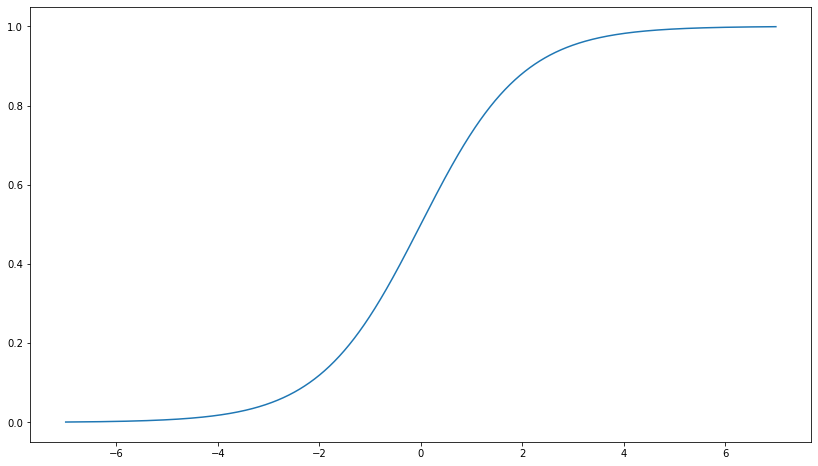

In [69]:
plt.figure(figsize = (14,8))
plt.plot(z, logit_z )
plt.show()